In [14]:
import zipfile
zip_path = "/content/MPA-MLF_DATA_NEW.zip"
extract_path = "/content/MPA_DATA"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


✅ Dataset extracted to: /content/MPA_DATA


In [24]:
import os
import numpy as np
import pandas as pd

def load_data():
    train_path = "/content/MPA_DATA/Train"
    test_path = "/content/MPA_DATA/Test"
    label_path = "/content/MPA_DATA/label_train.csv"

    # Load labels CSV
    labels_df = pd.read_csv(label_path)

    # Optional: print column names to check if they are as expected
    print("Columns:", labels_df.columns)

    # Initialize lists
    X_train = []
    y_train = []

    # Load training data
    for _, row in labels_df.iterrows():
        filename = str(row['ID']) + ".npy"       # CORRECTED: convert name to string
        label = row['target']
        filepath = os.path.join(train_path, filename)
        X_train.append(np.load(filepath))
        y_train.append(label)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Load test data
    X_test = []
    filenames_test = sorted(os.listdir(test_path))

    for fname in filenames_test:
        X_test.append(np.load(os.path.join(test_path, fname)))

    X_test = np.array(X_test)

    return X_train, y_train, X_test, filenames_test


In [25]:
X_train, y_train, X_test, test_filenames = load_data()
print("Train shape:", X_train.shape)
print("Labels shape:", y_train.shape)
print("Test shape:", X_test.shape)


Columns: Index(['ID', 'target'], dtype='object')
Train shape: (1491, 72, 48)
Labels shape: (1491,)
Test shape: (120, 72, 48)


In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Normalisation
X_train = np.array(X_train).astype("float32") / 255.0
X_test = np.array(X_test).astype("float32") / 255.0

# Ajout d'une dimension pour le canal (1 canal car images en niveaux de gris)
X_train = X_train.reshape(-1, 72, 48, 1)
X_test = X_test.reshape(-1, 72, 48, 1)

# One-hot encoding des labels
y_train_cat = to_categorical(y_train, num_classes=3)

# Split train / validation
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train, y_train_cat, test_size=0.2, random_state=42, shuffle=True
)


In [27]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential([
    layers.Input(shape=(72, 48, 1)),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 classes
])


In [29]:
optimizer = optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 72, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 36, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 36, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       884,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 904,195 (3.45 MB)

 Trainable params: 904,003 (3.45 MB)

 Non-trainable params: 192 (768.00 B)

In [30]:
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=30,
    batch_size=64,
    verbose=1
)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 466ms/step - accuracy: 0.9995 - loss: 0.0041 - val_accuracy: 0.9097 - val_loss: 0.2319
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 364ms/step - accuracy: 0.9995 - loss: 0.0066 - val_accuracy: 0.9264 - val_loss: 0.1186
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 374ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9431 - val_loss: 0.0995
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 372ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9866 - val_loss: 0.0481
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9866 - val_loss: 0.0441
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 446ms/step - accuracy: 0.9988 - loss: 0.0014 - val_accuracy: 0.9599 - val_loss: 0.0845
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 405ms/step - accuracy: 1.0000 - loss: 8.8540e-04 - val_accuracy: 0.9933 - val_loss: 0.0197
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - accuracy: 1.0000 - loss: 6.7622e-04 - val

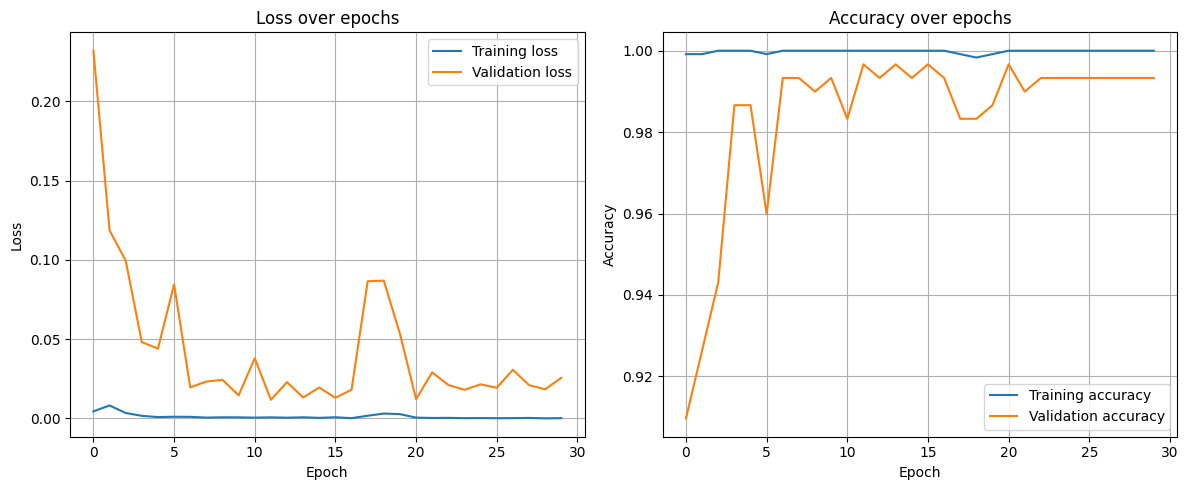

In [31]:
import matplotlib.pyplot as plt

# Courbe de perte (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Courbe de précision (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Prédictions
y_pred = model.predict(X_val_final)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_final, axis=1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


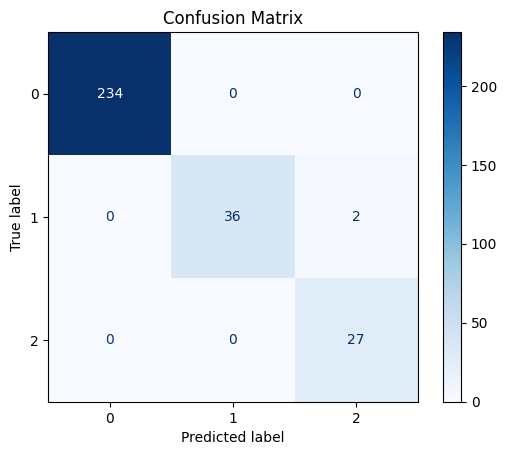

In [35]:
# Créer la matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()
